<a href="https://colab.research.google.com/github/ankitdsi2010/ECE_LBP/blob/main/QNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install qiskit

     |████████████████████████████████| 6.5 MB 4.5 MB/s 
     |████████████████████████████████| 18.0 MB 318 kB/s 
     |████████████████████████████████| 240 kB 76.0 MB/s 
     |████████████████████████████████| 200 kB 72.8 MB/s 
     |████████████████████████████████| 112 kB 72.3 MB/s 
     |████████████████████████████████| 54 kB 3.7 MB/s 
     |████████████████████████████████| 1.6 MB 47.5 MB/s 
     |████████████████████████████████| 49 kB 7.9 MB/s 
     |████████████████████████████████| 38.1 MB 1.2 MB/s 
     |████████████████████████████████| 49 kB 8.1 MB/s 
     |████████████████████████████████| 37.5 MB 28 kB/s 
     |████████████████████████████████| 943 kB 53.4 MB/s 
     |████████████████████████████████| 3.6 MB 51.4 MB/s 
     |████████████████████████████████| 113 kB 77.9 MB/s 
  Created wheel for qiskit: filename=qiskit-0.36.0-py3-none-any.whl size=11861 sha256=490a8478cc2c70a831faff869c32a2505ba9a51d2465d331f25a11ff1100fa6a
  Stored in directory: /root/.cache/pip/wheel

In [ ]:
!pip install qiskit-aer-gpu

     |████████████████████████████████| 21.6 MB 1.2 MB/s 


In [ ]:
!pip install pylatexenc

     |████████████████████████████████| 162 kB 8.0 MB/s 
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136835 sha256=c70da177ee764ed1219ad49825fa480e78251d8c82baf85d69158a2699361a48
  Stored in directory: /root/.cache/pip/wheels/f1/8a/f5/33ee79d4473eb201b519fa40f989b842e373237395a3421f52
Successfully built pylatexenc


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
from torch.autograd import Function
from torchvision import datasets, transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

import qiskit
from qiskit.visualization import *
from qiskit.circuit.random import random_circuit

from itertools import combinations

In [ ]:
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')

In [ ]:
BATCH_SIZE = 10 # Size of batch 
EPOCHS = 10     # Number of optimization epochs
n_layers = 1    # Number of random layers
n_train = 50    # Size of the train dataset
n_test = 30     # Size of the test dataset

SAVE_PATH = "quanvolution/" # Data saving folder
PREPROCESS = True           # If False, skip quantum processing and load data from SAVE_PATH
seed = 47
np.random.seed(seed)        # Seed for NumPy random number generator
torch.manual_seed(seed) 

In [ ]:
train_dataset = datasets.MNIST(root = "./data",
                               train = True,
                               download = True,
                               transform = transforms.ToTensor())

train_dataset.data    = train_dataset.data[:n_train]
train_dataset.targets = train_dataset.targets[:n_train]

test_dataset = datasets.MNIST(root = "./data",
                              train = False,
                              transform = transforms.ToTensor())

test_dataset.data    = test_dataset.data[:n_test]
test_dataset.targets = test_dataset.targets[:n_test]

train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = BATCH_SIZE,
                                           shuffle = True)

test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                          batch_size = BATCH_SIZE,
                                          shuffle = False)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



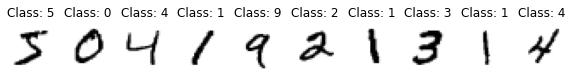

In [ ]:
pltsize = 1
plt.figure(figsize=(10 * pltsize, pltsize))
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.axis('off')
    plt.imshow(train_dataset.data[i, :, :].numpy().reshape(28, 28), cmap = "gray_r")
    plt.title('Class: ' + str(train_dataset.targets[i].item()))

In [ ]:
class QuanvCircuit:
    """ 
    This class defines filter circuit of Quanvolution layer
    """
    
    def __init__(self, kernel_size, backend, shots, threshold):
        # --- Circuit definition start ---
        self.n_qubits = kernel_size ** 2
        self._circuit = qiskit.QuantumCircuit(self.n_qubits)
        self.theta = [qiskit.circuit.Parameter('theta{}'.format(i)) for i in range(self.n_qubits)]

        for i in range(self.n_qubits):
            self._circuit.rx(self.theta[i], i)
        
        self._circuit.barrier()
        self._circuit += random_circuit(self.n_qubits, 2)
        self._circuit.measure_all()
        # ---- Circuit definition end ----

        self.backend   = backend
        self.shots     = shots
        self.threshold = threshold

    def run(self, data):
        # data shape: tensor (1, 5, 5)
        # val > self.threshold  : |1> - rx(pi)
        # val <= self.threshold : |0> - rx(0)

        # reshape input data
        # [1, kernel_size, kernel_size] -> [1, self.n_qubits]
        data = torch.reshape(data, (1, self.n_qubits))

        # encoding data to parameters
        thetas = []
        for dat in data:
            theta = []
            for val in dat:
                if val > self.threshold:
                    theta.append(np.pi)
                else:
                    theta.append(0)
            thetas.append(theta)
        
        param_dict = dict()
        for theta in thetas:
            for i in range(self.n_qubits):
                param_dict[self.theta[i]] = theta[i]
        param_binds = [param_dict]

        # execute random quantum circuit
        job = qiskit.execute(self._circuit, 
                             self.backend, 
                             shots = self.shots, 
                             parameter_binds = param_binds)
        result = job.result().get_counts(self._circuit)

        # decoding the result
        counts = 0
        for key, val in result.items():
            cnt = sum([int(char) for char in key])
            counts += cnt * val

        # Compute probabilities for each state
        probabilities = counts / (self.shots * self.n_qubits)
        # probabilities = counts / self.shots
        
        return probabilities

In [ ]:
backend = qiskit.Aer.get_backend("aer_simulator_statevector_gpu")
filter_size = 2
circ = QuanvCircuit(filter_size, backend, 100, 127)
circ._circuit.draw()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: DeprecationWarning: The QuantumCircuit.__iadd__() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  app.launch_new_instance()


┌────────────┐ ░                          ░ ┌─┐         
   q_0: ┤ Rx(theta0) ├─░───X────■─────────────────░─┤M├─────────
        ├────────────┤ ░   │  ┌─┴─┐               ░ └╥┘┌─┐      
   q_1: ┤ Rx(theta1) ├─░───■──┤ X ├───────────────░──╫─┤M├──────
        ├────────────┤ ░   │  └─┬─┘┌────────────┐ ░  ║ └╥┘┌─┐   
   q_2: ┤ Rx(theta2) ├─░───X────┼──┤ Rx(5.6782) ├─░──╫──╫─┤M├───
        ├────────────┤ ░ ┌───┐  │  └────────────┘ ░  ║  ║ └╥┘┌─┐
   q_3: ┤ Rx(theta3) ├─░─┤ I ├──■─────────────────░──╫──╫──╫─┤M├
        └────────────┘ ░ └───┘                    ░  ║  ║  ║ └╥┘
meas: 4/═════════════════════════════════════════════╩══╩══╩══╩═
                                                     0  1  2  3

In [ ]:
class QuanvFunction(Function):
    """ Quanv function definition """
    
    @staticmethod
    def forward(ctx, inputs, in_channels, out_channels, kernel_size, quantum_circuits, shift):
        """ Forward pass computation """
        # input  shape : (-1, 1, 28, 28)
        # otuput shape : (-1, 6, 24, 24)
        ctx.in_channels      = in_channels
        ctx.out_channels     = out_channels
        ctx.kernel_size      = kernel_size
        ctx.quantum_circuits = quantum_circuits
        ctx.shift            = shift

        _, _, len_x, len_y = inputs.size()
        len_x = len_x - kernel_size + 1
        len_y = len_y - kernel_size + 1
        
        outputs = torch.zeros((len(inputs), len(quantum_circuits), len_x, len_y)).to(DEVICE)
        for i in range(len(inputs)):
            print(f"batch{i}")
            input = inputs[i]
            for c in range(len(quantum_circuits)):
                circuit = quantum_circuits[c]
                print(f"channel{c}")
                for h in range(len_y):
                    for w in range(len_x):
                        data = input[0, h:h+kernel_size, w:w+kernel_size]
                        outputs[i, c, h, w] = circuit.run(data)
                        # print(f"({h},{w})")
        
        ctx.save_for_backward(inputs, outputs)
        return outputs

    @staticmethod
    def backward(ctx, grad_output): # 확인 필요(검증 x)
        """ Backward pass computation """
        input, expectation_z = ctx.saved_tensors
        input_list = np.array(input.tolist())
        
        shift_right = input_list + np.ones(input_list.shape) * ctx.shift
        shift_left = input_list - np.ones(input_list.shape) * ctx.shift
        
        gradients = []
        for i in range(len(input_list)):
            expectation_right = ctx.quantum_circuit.run(shift_right[i])
            expectation_left  = ctx.quantum_circuit.run(shift_left[i])
            
            gradient = torch.tensor([expectation_right]) - torch.tensor([expectation_left])
            gradients.append(gradient)
        gradients = np.array([gradients]).T
        return torch.tensor([gradients]).float() * grad_output.float(), None, None


class Quanv(nn.Module):
    """ Quanvolution(Quantum convolution) layer definition """
    
    def __init__(self, in_channels, out_channels, kernel_size, 
                 backend=qiskit.providers.aer.QasmSimulator(method="statevector_gpu"), 
                 shots=100, shift=np.pi/2):
        super(Quanv, self).__init__()
        self.quantum_circuits = [QuanvCircuit(kernel_size=kernel_size, 
                                              backend=backend, shots=shots, threshold=127) 
                                 for i in range(out_channels)]
        self.in_channels  = in_channels
        self.out_channels = out_channels
        self.kernel_size  = kernel_size
        self.shift        = shift
        
    def forward(self, inputs):
        return QuanvFunction.apply(inputs, self.in_channels, self.out_channels, self.kernel_size,
                                   self.quantum_circuits, self.shift)

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.quanv = Quanv(in_channels=1, out_channels=1, kernel_size = 3) # <- Quanv!!!!
        self.conv = nn.Conv2d(1, 16, kernel_size=5)
        self.dropout = nn.Dropout2d()
        self.fc1 = nn.Linear(256, 64)
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        x = F.relu(self.quanv(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv(x))
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        # x = x.view(-1, 256)
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x)

In [ ]:
model = Net().to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.CrossEntropyLoss()

epochs = 20
loss_list = []

model.train().to(DEVICE)
for epoch in range(epochs):
    total_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        target = target.to(DEVICE)
        optimizer.zero_grad()

        # Forward pass
        output = model(data).to(DEVICE)

        # Calculating loss
        loss = loss_func(output, target).to(DEVICE)
        
        # Backward pass
        loss.backward()
        
        # Optimize the weights
        optimizer.step()
        
        total_loss.append(loss.item())
    loss_list.append(sum(total_loss)/len(total_loss))
    print('Training [{:.0f}%]\tLoss: {:.4f}'.format(
        100. * (epoch + 1) / epochs, loss_list[-1]))